In [4]:
%matplotlib inline
import pandas as pd
from pandas_datareader import data
import datetime
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.pylab import style
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

style.use('ggplot')    
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

# Import the data

In [5]:
stock_info = data.get_data_yahoo('002424.SZ','2017-01-01','2020-02-28')
stock_info.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-02-21,9.28,9.13,9.23,9.25,9925509.0,9.25
2020-02-24,9.45,9.23,9.25,9.38,10886491.0,9.38
2020-02-25,9.59,9.21,9.30,9.50,17890444.0,9.50
2020-02-26,9.46,9.20,9.41,9.23,12357403.0,9.23
2020-02-28,9.24,8.93,9.05,8.93,8391816.0,8.93


In [6]:
stock_info = stock_info.resample('D').ffill()

In [7]:
# We can choose the data from 2018-07-28 until now as our training data
stock_train = stock_info[:'2020-01-01']['Adj Close'].dropna()
stock_test = stock_info['2020-01-01':]['Adj Close'].dropna()
stock_train.head()

Date
2017-01-03    18.543560
2017-01-04    18.474842
2017-01-05    18.651543
2017-01-06    18.327595
2017-01-07    18.327595
Freq: D, Name: Adj Close, dtype: float64

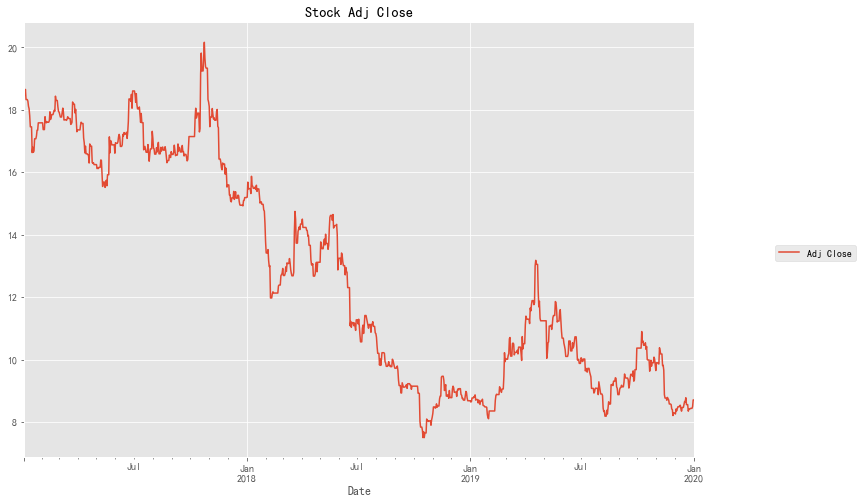

In [8]:
# Visulize the stock data's adjusted close price
stock_train.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Stock Adj Close")
sns.despine()

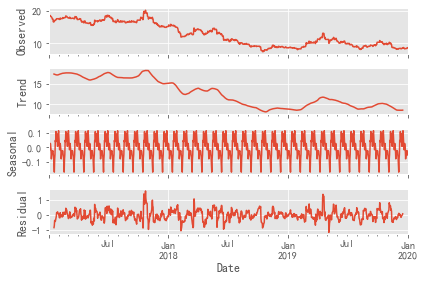

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
season = seasonal_decompose(stock_train, freq = 30)
season.plot()
plt.show()
# Clearly, the data is decreasing

In [10]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(stock_train,regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.48365652188090136


In [11]:
#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(stock_train.diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:0.0


From results,We decided that Original time series is not stational.
We will try to using ARIMA model.

(<matplotlib.axes._subplots.AxesSubplot at 0xd0a1e08>,
 <matplotlib.axes._subplots.AxesSubplot at 0xd19f608>)

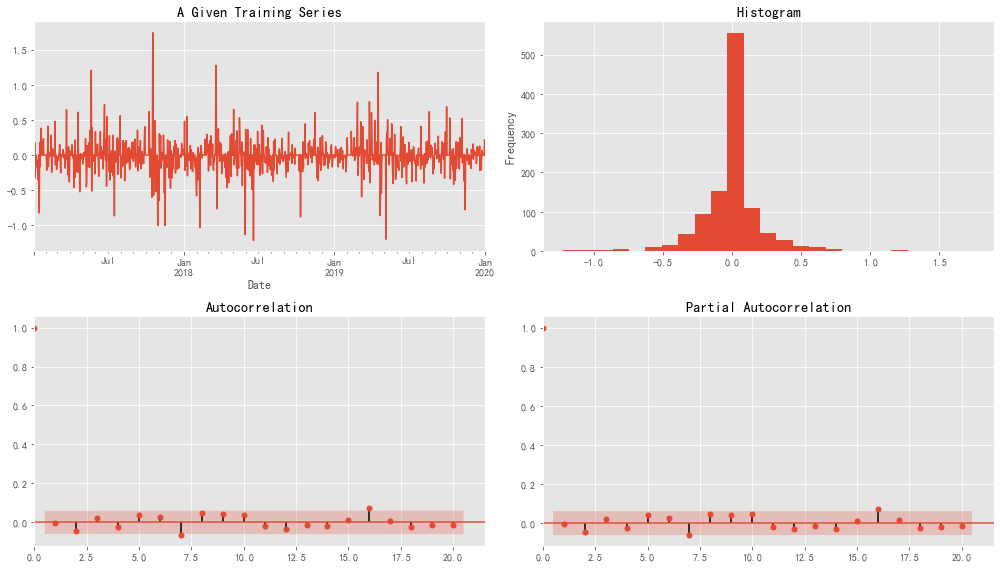

In [12]:
stock_train_diff = stock_train.diff().dropna()

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

tsplot(stock_train_diff, title='A Given Training Series', lags=20)

From the graph, the best choice is ARIMA(0,1,0)

In [ ]:
# We can use BIC is the benchmark to validate our choice
resDiff = sm.tsa.arma_order_select_ic(stock_train_diff, max_ar=5, max_ma=5, ic='bic', trend='c')
print('ARMA(p,q) =',resDiff['bic_min_order'],'is the best.')

## ARIMA Model

In [13]:
arima = sm.tsa.statespace.SARIMAX(stock_train,order=(0,1,0),seasonal_order=(0,0,0,0),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1094
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  95.077
Date:                Fri, 28 Feb 2020   AIC                           -188.154
Time:                        14:51:24   BIC                           -183.158
Sample:                    01-03-2017   HQIC                          -186.263
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0492      0.001     57.681      0.000       0.048       0.051
===================================================================================
Ljung-Box (Q):                       49.47   Jarque-Bera (JB):              4803.93
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

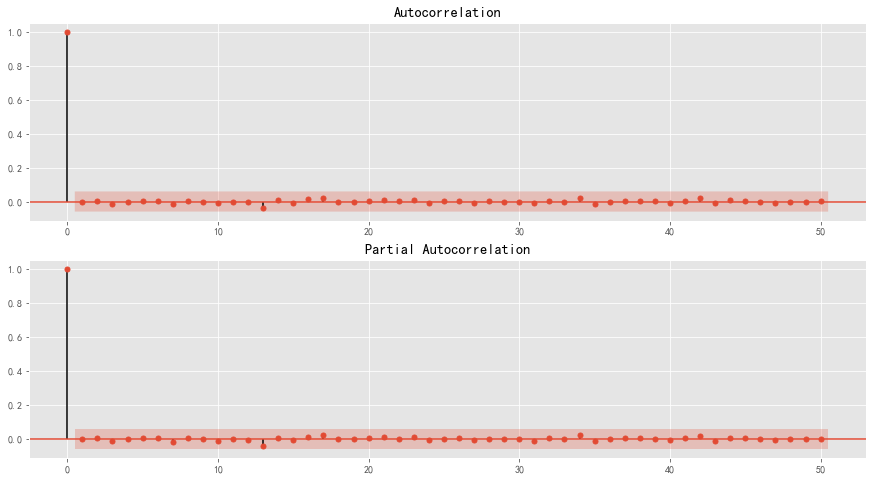

In [14]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
pred = arima.predict('2020-01-01','2020-02-28')
print('ARIMA model MSE:{}'.format(mean_squared_error(stock_test,pred)))

ARIMA model MSE:0.3928965274617594


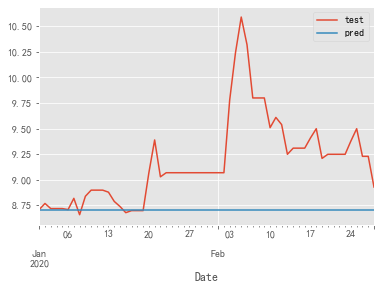

In [16]:
pd.DataFrame({'test':stock_test,'pred':pred}).plot()
plt.show()

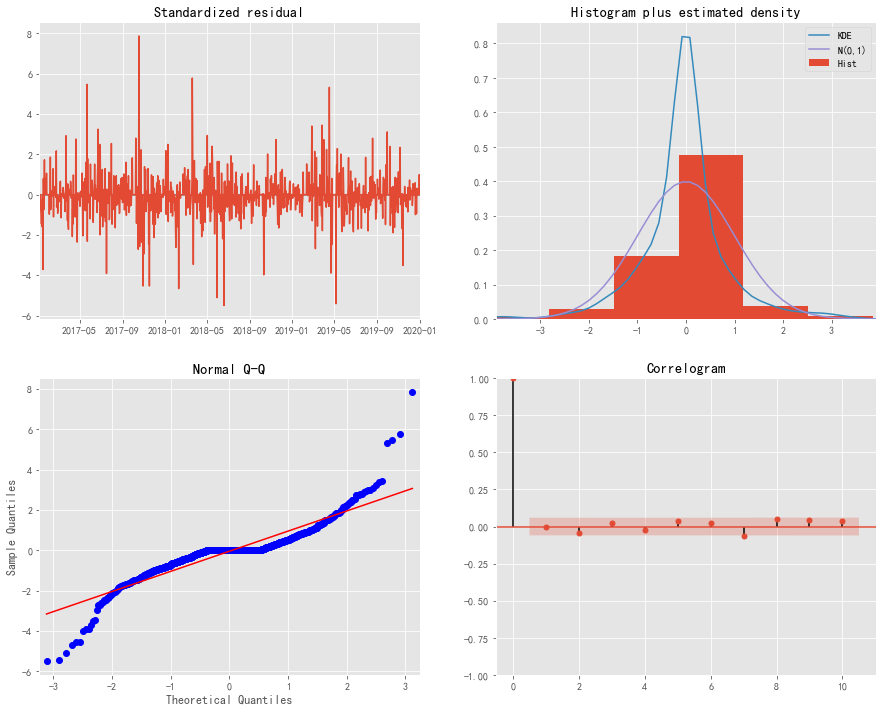

In [30]:
arima.plot_diagnostics(figsize=(15, 12))
plt.show()

# SARIMA

In [52]:
sarima = sm.tsa.statespace.SARIMAX(stock_train,order=(0,1,0),seasonal_order=(0,1,0,12),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                 1094
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -299.786
Date:                            Fri, 28 Feb 2020   AIC                            601.572
Time:                                    15:24:16   BIC                            606.556
Sample:                                01-03-2017   HQIC                           603.459
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1020      0.002     52.491      0.000       0.098       0.106
===================================================================================
Ljung-Box (Q):                      311.80   Jarque-Bera (JB):              3068.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

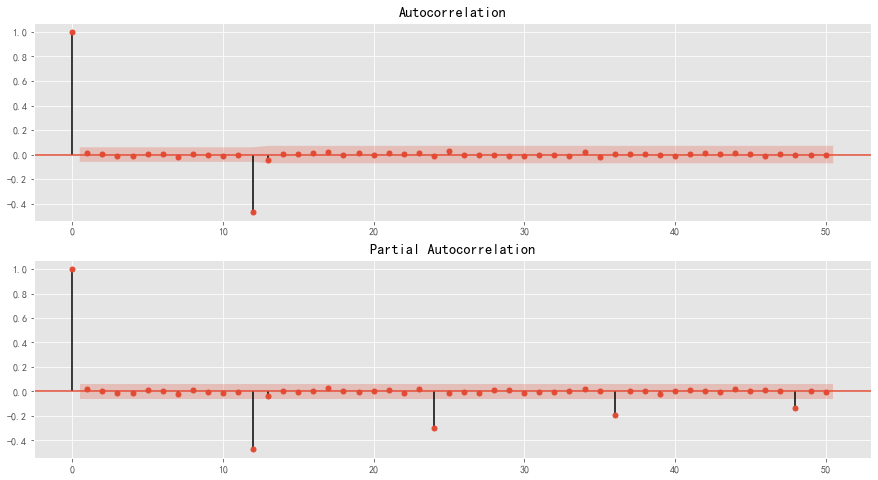

In [53]:
s_res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(s_res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(s_res, lags=50, ax=ax[1])
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
pred_s = sarima.predict('2020-01-01','2020-02-28')
print('ARIMA model MSE:{}'.format(mean_squared_error(stock_test,pred_s)))

ARIMA model MSE:0.174049732561145


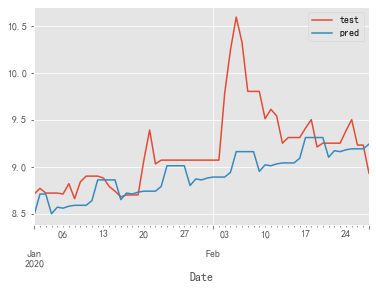

In [20]:
pd.DataFrame({'test':stock_test,'pred':pred_s}).plot()
plt.show()

In [25]:
# Try to find the best parameters
s_lst = [1,4,12,52]
best = 0
MSE = 10
for s in s_lst:
    sarima = sm.tsa.statespace.SARIMAX(stock_train,order=(0,1,0),seasonal_order=(0,1,0,s),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
    pred_s = sarima.predict('2020-01-01','2020-02-28')
    mse = mean_squared_error(stock_test,pred_s)
    if mse < MSE:
        MSE = mse
        best = s
print('Best coefficient is {} with its MSE {}'.format(best,MSE))

Best coefficient is 12 with its MSE 0.174049732561145


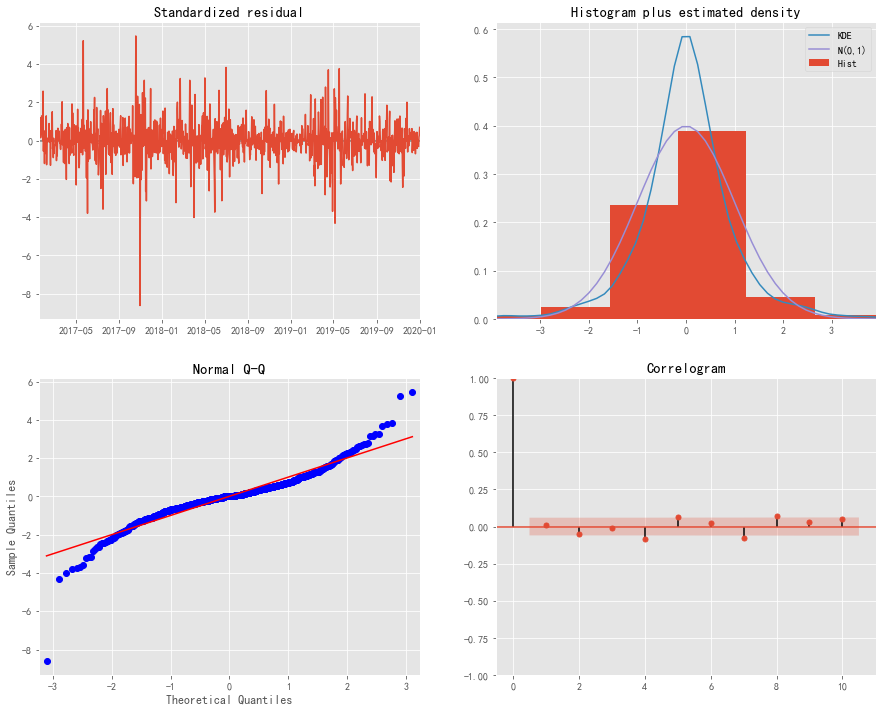

In [29]:
# Therefore, we can see that 12 is a good choice
# We can see
sarima = sm.tsa.statespace.SARIMAX(stock_train,order=(0,1,0),seasonal_order=(0,1,0,12),
                                   enforce_stationarity=False, enforce_invertibility=False).fit()

sarima.plot_diagnostics(figsize=(15, 12))
plt.show()

We can see that the SARIMA has a better performance, but the residual plot shows it doesn't have a normal distribution.
Or can we try to do some transformation on the data?

In [76]:
import numpy as np
log_train = np.log(stock_train)
log_test = np.log(stock_test)

<function matplotlib.pyplot.show(*args, **kw)>

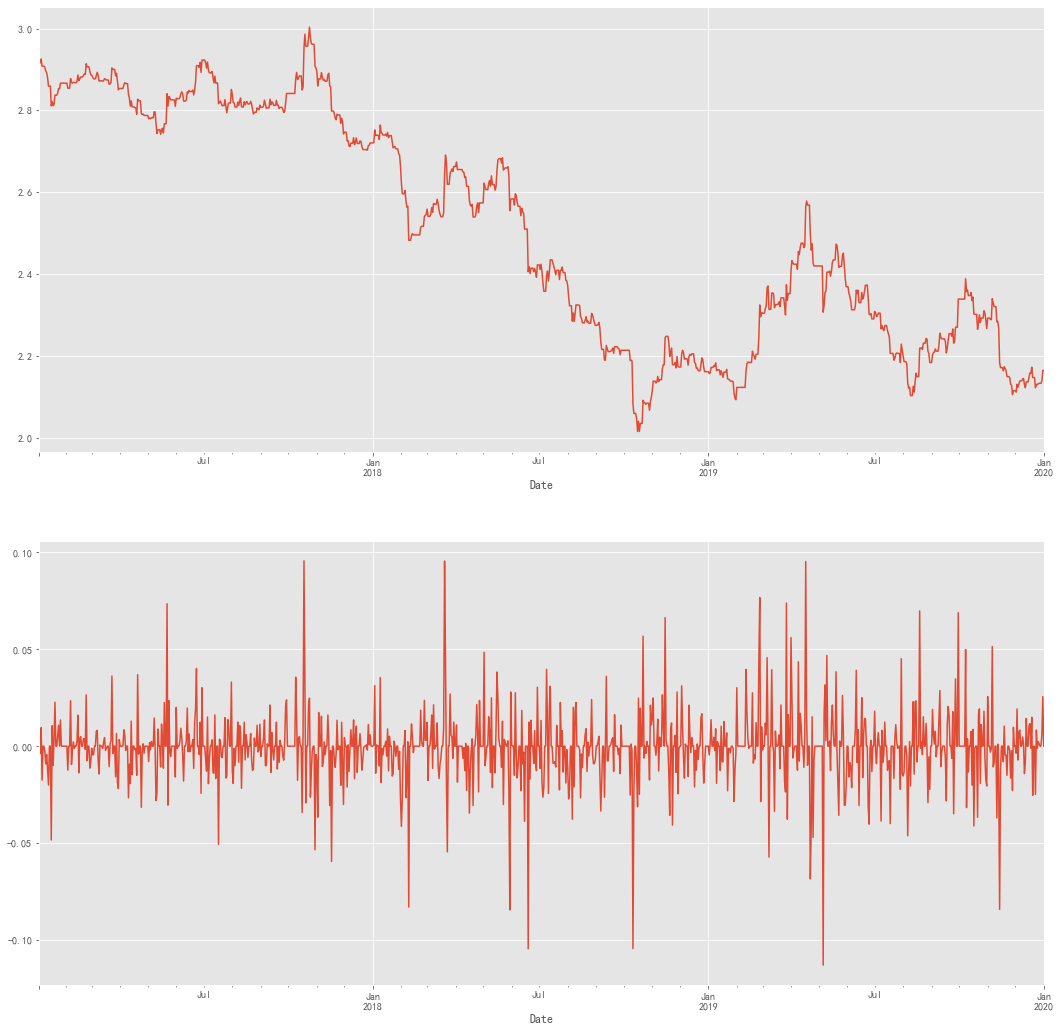

In [77]:
plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
log_train.plot()
plt.subplot(2,1,2)
log_train.diff().plot()
plt.show

(<matplotlib.axes._subplots.AxesSubplot at 0x2be30608>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2bcbae88>)

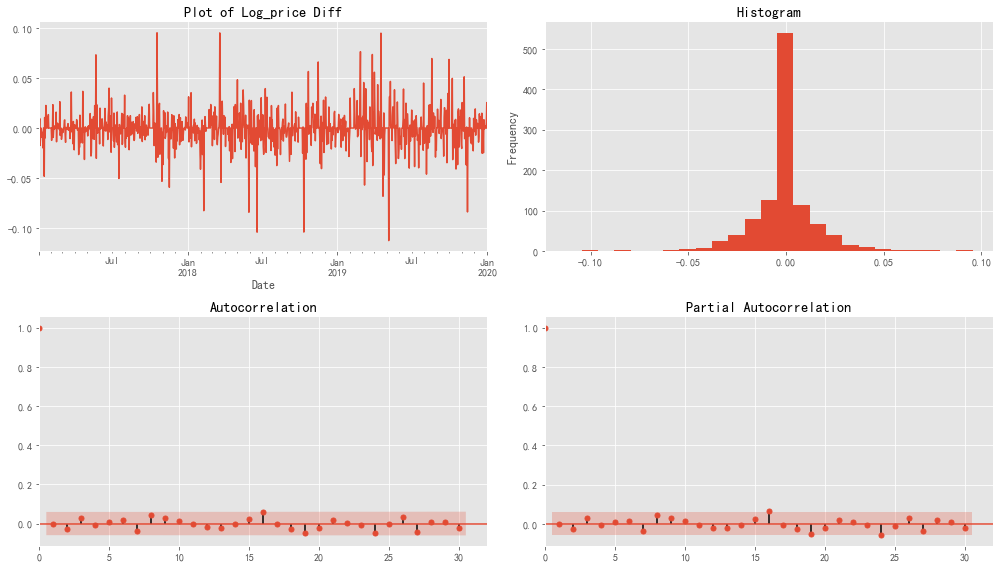

In [78]:
log_train_diff = log_train.diff(1).dropna()
log_test_diff = log_test.diff(1).dropna()
tsplot(log_train_diff, title='Plot of Log_price Diff', lags=30)

In [79]:
# Try to find the best parameters
s_lst = [1,4,12,52]
best = 0
MSE = 10
for s in s_lst:
    sarima = sm.tsa.statespace.SARIMAX(log_train,order=(0,1,0),seasonal_order=(0,1,0,s),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
    pred_s = sarima.predict('2020-01-01','2020-02-28')
    pred_ss = np.exp(pred_s)
    mse = mean_squared_error(stock_test,pred_ss)
    if mse < MSE:
        MSE = mse
        best = s
print('Best coefficient is {} with its MSE {}'.format(best,MSE))

F:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best coefficient is 12 with its MSE 0.1710289681159454


In [80]:
sarima_log = sm.tsa.statespace.SARIMAX(log_train,order=(0,1,0),seasonal_order=(0,1,0,12),
                              enforce_stationarity=False, enforce_invertibility=False).fit()
pred_s = sarima_log.predict('2020-01-01','2020-02-28')
pred_ss = np.exp(pred_s)

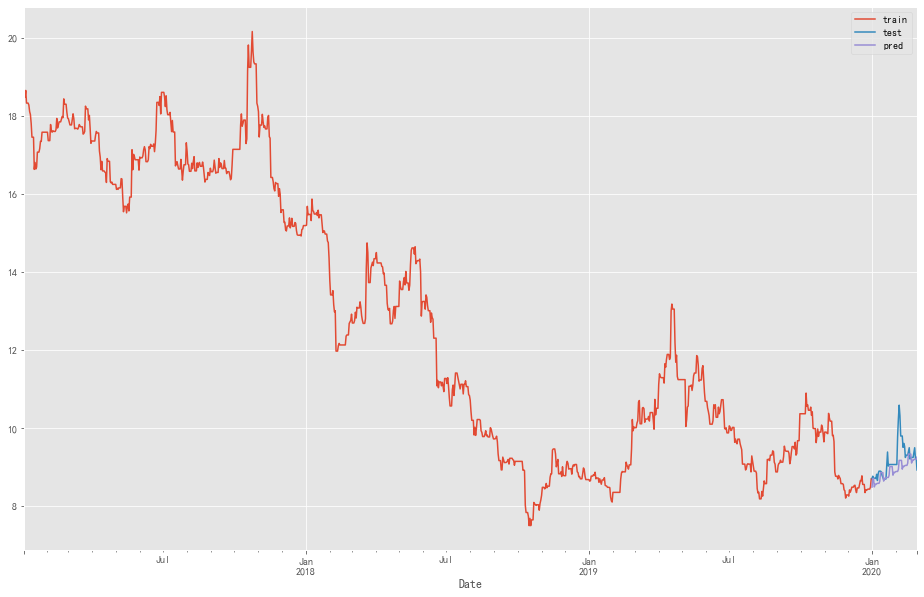

In [95]:
pd.DataFrame({'train':stock_train, 'test':stock_test,'pred':pred_ss}).plot(figsize = (16,10))
plt.show()